In [2]:
import numpy as np
import pandas as pd

from sklearn import metrics
from scipy.stats import pearsonr, chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler



import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

## 2. Preprocesing B
### 2.1 Reinspect Data

In [3]:
data = pd.read_csv('../app/data/wrangled_data.csv')
# 2.2.1 Inspect Table
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3821 entries, 0 to 3820
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       3821 non-null   object 
 1   description   3821 non-null   object 
 2   location      3821 non-null   object 
 3   rating        3821 non-null   float64
 4   requirements  80 non-null     object 
 5   summary       3821 non-null   object 
 6   job_title     3821 non-null   object 
 7   url           3821 non-null   object 
 8   text          3821 non-null   object 
 9   salary        1650 non-null   float64
 10  dateposted    3821 non-null   object 
 11  state         3821 non-null   object 
 12  city          3821 non-null   object 
dtypes: float64(2), object(11)
memory usage: 64.3 MB


,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,recruiting from scratch,who is recruiting from scratch: recruiting fro...,"remote in huntsville, al",0.0,NaN,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...,who is recruiting from scratch: recruiting fro...,180000.0,2022-06-21,al,remote in huntsville
1,food management search,sr financial data analyst- fully remote - any ...,remote in united states,0.0,NaN,lead various allocation data analysis projects...,sr financial data analyst- fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,sr financial data analyst- fully remote - any ...,NaN,2022-06-21,remote in united states,remote in united states
2,gregor diagnostics,role: senior data scientistabout gregor diagno...,remote in united states,0.0,NaN,the senior data scientist will work closely la...,senior data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,role: senior data scientistabout gregor diagno...,NaN,2022-06-20,remote in united states,remote in united states
3,synergisticit,"at synergisticit, we aim to bring aboard it ...",alabama,4.2,NaN,"collaborate with dynamic teams of engineers, d...",entry level data scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...,"at synergisticit, we aim to bring aboard it ...",88000.0,2022-06-20,alabama,alabama
4,9rooftops,we are hiring in multiple locations across the...,"birmingham, al 35242",0.0,NaN,o communication skills to ask questions of cli...,statistician/data scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...,we are hiring in multiple locations across the...,124000.0,2022-06-20,al,birmingham


From the info table I can see that the only missing values are for the Salary target feature. However, for duplicates it would 'seem' that almost all of my data is duplicated.\
It appears this way because an absolutely distinguishing feature has been removed, the url. That's what these duplicates are, individual records for multiple openings (records/observations,singular data). How this affects NLP and ML will be part of the ongoing discovery process.

In [4]:
print(data.company.unique()[:10])

['recruiting from scratch' 'food management search' 'gregor diagnostics'
 'synergisticit' '9rooftops' 'ierus technologies, inc.' 'usaa'
 'emd electronics' 'aural analytics, inc' 'intersources inc.']


In [5]:
data.describe(include='all')

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
count,3821,3821,3821,3821.000000,80,3821,3821,3821,3821,1650.000000,3821,3821,3821
unique,195,267,286,NaN,11,268,218,521,285,NaN,3,63,213
top,recruiting from scratch,who is recruiting from scratch: recruiting fro...,"cambridge, ma",NaN,sql: 5 years (preferred)oracle: 5 years (prefe...,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=2dc6650fabad3...,who is recruiting from scratch: recruiting fro...,NaN,2022-06-22,ma,boston
freq,219,219,231,NaN,16,201,483,63,201,NaN,1836,927,267
mean,NaN,NaN,NaN,2.511463,NaN,NaN,NaN,NaN,NaN,124285.454545,NaN,NaN,NaN
std,NaN,NaN,NaN,1.815056,NaN,NaN,NaN,NaN,NaN,32181.871650,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,55000.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,102000.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,NaN,120000.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,3.900000,NaN,NaN,NaN,NaN,NaN,142000.000000,NaN,NaN,NaN


In [6]:
(114 + 144)/2

129.0

### 2.2 Univariate Feature Analysis & Centering
I'm going to employ visual and statistical methods to analyze each feature, starting with the target, and outside of scaling, prepare them for logistic regression which will require that each feature's vaues are normally distributes.


### 2.2a Target

In [7]:
col = 'salary'
eda_data = data[data[col]>1]

### Detecting Outliers: Using both the Z-Score and IQR methods
Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

To explore the possibility of outliers I'll start with a box and whisker plot. Those whisters reach 1.5 times past the IQR boundary on either side, and are generally provide a good means of identifying outliers - values beyond the boundaries.

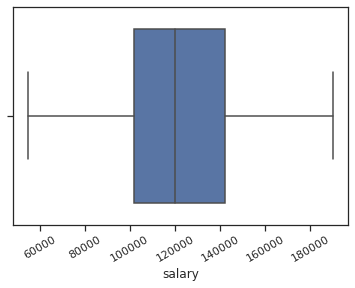

In [8]:
sns.boxplot(data=eda_data, x='salary')
plt.xticks(rotation=30)
plt.show()

To observe the impact this has on the target's shape I'll employ a KDE plot.

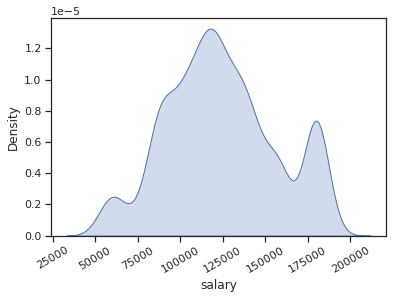

In [9]:
sns.kdeplot(eda_data.salary, shade=True)
plt.xticks(rotation=30)
plt.show()

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.\
Here we can see that there are five records with salary values outside the Z-score threshold.

In [10]:
outliers = []
def z_detect(data):
    sample = data[data['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(data)

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.\
Here, I clearly demarcate the quartiles as well as the uppet and lower boundaries. Before removing these outliers let's take a look.

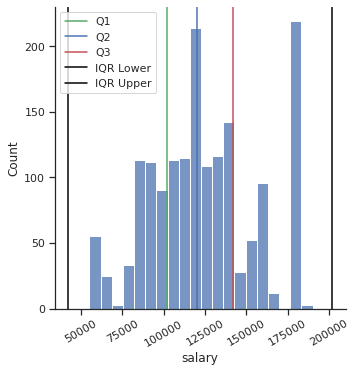

In [11]:
q1 = np.quantile(eda_data.salary, 0.25)
q2 = np.quantile(eda_data.salary, 0.5)
q3 = np.quantile(eda_data.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(eda_data.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = 'b')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [12]:
data.salary.value_counts().nunique()

31

In [13]:
q3

142000.0

In [14]:
np.percentile(eda_data.salary, 50)

120000.0

<AxesSubplot:xlabel='salary', ylabel='Count'>

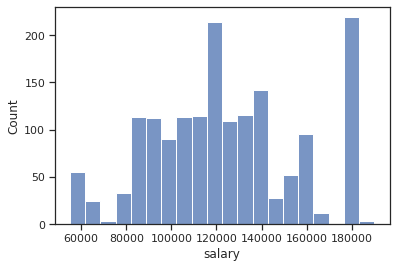

In [15]:
sns.histplot(data.salary)

There aren't any outliers beyond the lower bound for either test so let's take a look at what's above the IQR threshold.\
While not guarenteed, its a good thing that both tests seem to identify the same five records, the salary values match.

In [16]:
data[data.salary > iqr_upper]

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city


Trimming the data, while showing the number of records were starting with and how many remain after removing the outliers viewed above.

In [17]:
print(len(data))
data1 = data[data.salary <= iqr_upper]
data2 = data[data.salary.isnull()]
data = pd.concat([data1,data2])
print(len(data))
eda_data = data[data[col]>1]

3821
3821


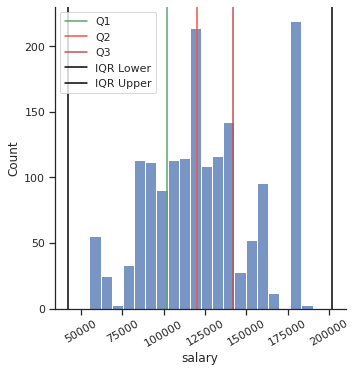

In [18]:
q1 = np.quantile(eda_data.salary, 0.25)
q2 = np.quantile(eda_data.salary, 0.5)
q3 = np.quantile(eda_data.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(eda_data.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.xticks(rotation=30)
plt.show()




Excellent, everything falls within the boundaries. While there are a number of reccords off in the high end, neither test detects them as outliers, let's check with a box and whisker plot though.

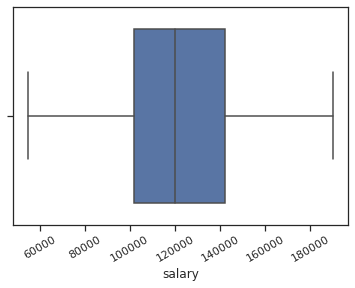

In [19]:
sns.boxplot(data=data, x='salary')
plt.xticks(rotation=30)
plt.show()

Modality might be an issue but it's something I can come back and fine tune later.

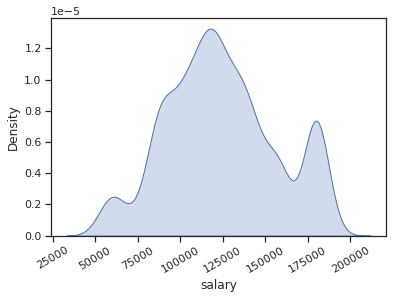

In [20]:
#TODO check on this modality.
sns.kdeplot(eda_data.salary, shade=True)
plt.xticks(rotation=30)
plt.show()




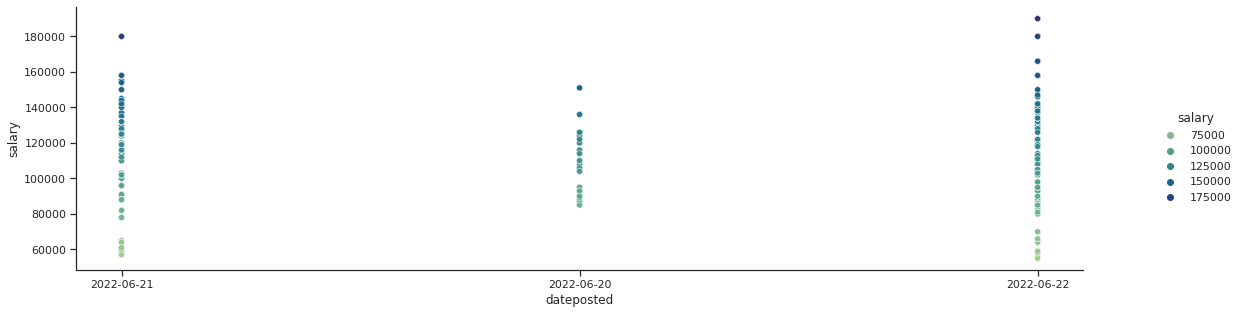

In [21]:
ax = sns.pairplot(data=data[data.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=10, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

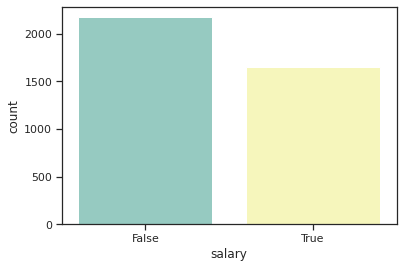

In [23]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()


In [24]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

43.18% of the data has salary information, should be an easy target


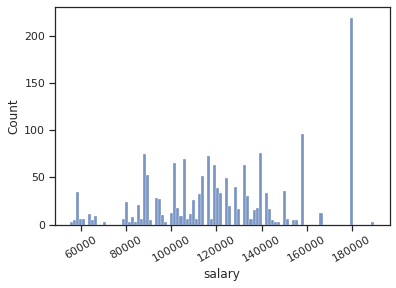

In [25]:
sns.histplot(data,x='salary',bins=100)
plt.xticks(rotation=30)
plt.show()

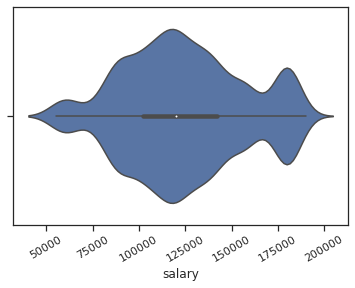

In [26]:
sns.violinplot(x="salary", data=data)
plt.xticks(rotation=30)
plt.show()

In [27]:
def Q(row):
    """Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """

    salary = row['salary']
    if salary < q1:
        return 1
    if (salary >= q1) & (salary < q2):
        return 2
    if (salary >= q2) & (salary < q3):
        return 3
    if salary >= q3:
        return 4
    else:
        return np.nan


data['target'] = data.apply( lambda row : Q(row), axis = 1)

In [28]:
q1

102000.0

In [29]:
q2

120000.0

In [30]:
q3

142000.0

In [31]:
np.quantile(data.salary, .5)

nan

A new target variable has been created and its values are nan, 1, 2, 3, and 4 - representing the unknown set, and four labels for the taget.

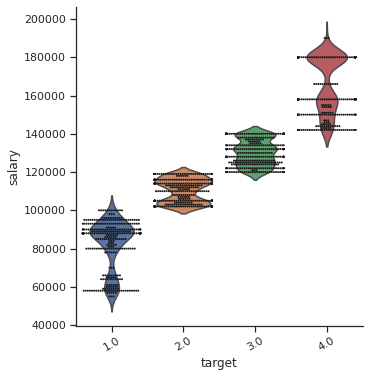

In [32]:
g = sns.catplot(x="target", y="salary", kind="violin", inner=None, data=data)
sns.swarmplot(x="target", y="salary", color="k", size=2, data=data, ax=g.ax)

plt.xticks(rotation=30)

plt.show()

<AxesSubplot:xlabel='salary'>

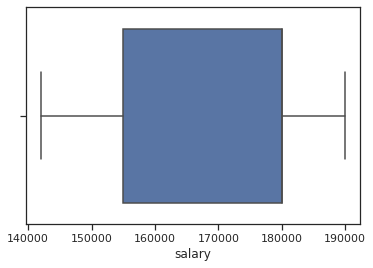

In [33]:
sns.boxplot(data=data[data.target == 4],x='salary')

And checking each target value for outliers

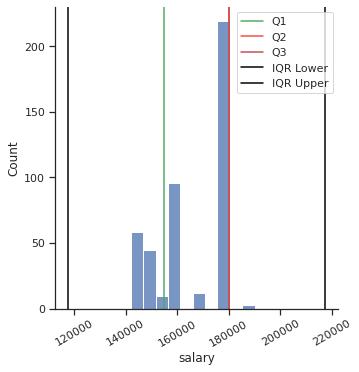

In [34]:
check = data[data.target == 4]
q1 = np.quantile(check.salary, 0.25)
q2 = np.quantile(check.salary, 0.5)
q3 = np.quantile(check.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(check.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.xticks(rotation=30)
plt.show()

'company'\
There's presently 96 different companies - that's a ton of dimensions added to the data, and I've still got to add count vectorizer. I'll try label encoding these. In the future, shifting these into clusters might be useful.\
Other than that, this variable doesn't seem to need much - 

In [35]:
data.company.value_counts()

recruiting from scratch                         219
amazon.com services llc                         195
food management search                          147
parexel                                         117
disney parks,parks, experiences and products    112
                                               ... 
tulk llc                                          3
us tech solutions private limited                 3
regional finance                                  3
clozd                                             3
shield ai                                         3
Name: company, Length: 195, dtype: int64

'rating'\
Roughly a third of the data is missing values for the company rating feature. At first I used np.fillna(0) to imput 0 for all the missing values but that sharply right-skewed the distribution towards zero.\
Then I checked is scaling the data would fix the bi-modality but I think I have two options here, drop all those records or drop a potentially valuable feature.\
For now, I'll drop the records, I can always get more, and in the future I could conduct linear regression to imput the values.

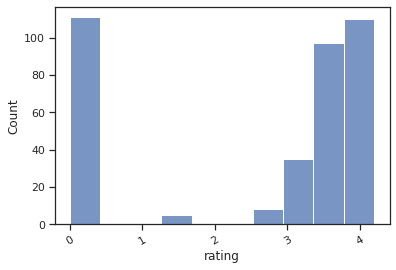

In [36]:
#TODO imput the rating with a regressor.
sns.histplot(data=data[data.target ==1], x='rating')
plt.xticks(rotation=30)
plt.show()

data.primarytitle.value_counts()

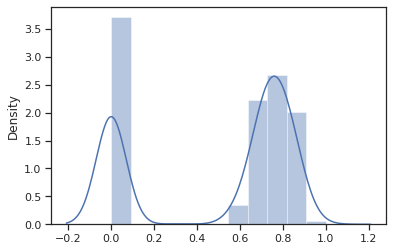

In [37]:
scale = MinMaxScaler()
scale = scale.fit_transform(pd.DataFrame(data['rating']))
sns.distplot(scale)
plt.show()

In [1]:
data = data[data.rating > 0]
len(data)


NameError: name 'data' is not defined

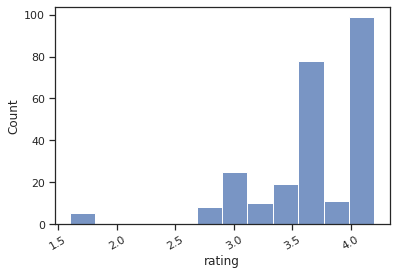

In [39]:
sns.histplot(data=data[data.target ==1], x='rating')
plt.xticks(rotation=30)
plt.show()

'job_title'\
Oddly enough, these number as many as company, I suspect multicolinearity. I'll come back to collapse these a bit and perhaps build a new feature for specializations out of these.
To be label encoded and possibly clustered later.

In [40]:
data.job_title.value_counts()

data scientist                                                     111
data scientist, namr people team                                   110
senior data scientist                                               89
entry level data scientist                                          78
machine learning engineer                                           77
                                                                  ... 
senior data scientist - medicare growth analytics (sql, pyth...      3
(usa) data scientist                                                 3
senior data scientist (experienced level professional)               2
data review scientist                                                2
principle data scientist (experienced level professional)            2
Name: job_title, Length: 180, dtype: int64

'dateposted'
This isn't going into the pipelie, despite some interesting patterns, I don't think there's enough periodic/seasonality information available here. Still, great for visualizing the job market.

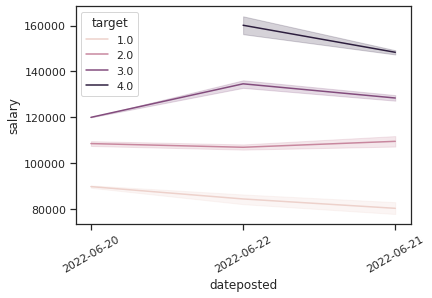

In [41]:
sns.lineplot(x="dateposted", y="salary", hue="target", data=data)
plt.xticks(rotation=30)
plt.show()

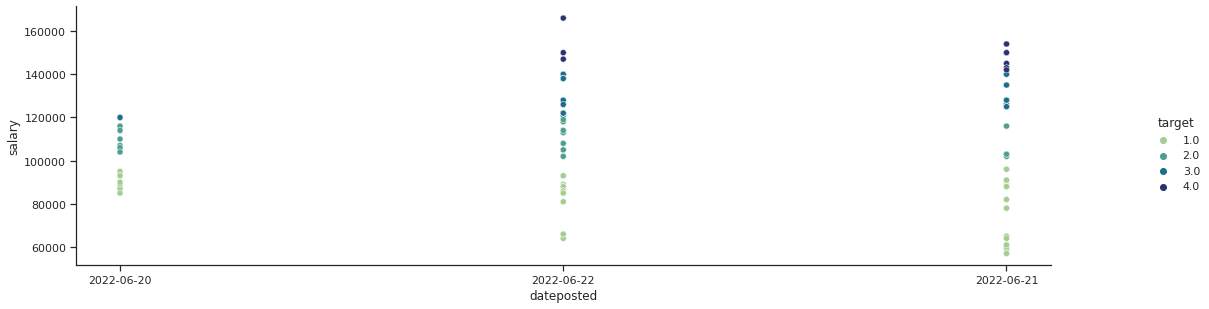

In [42]:
ax = sns.pairplot(data=data,
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="target", palette="crest")

ax.fig.set_size_inches(18,4)

In [43]:
len(data.city.value_counts())

160

In [44]:
len(data.state.value_counts())

56

## Feature Associations

In [45]:
data2 = data.drop('salary', axis=1)
data2.dropna(inplace=True)

In [46]:
target = 'target'

associated = []

for i in data2.select_dtypes('number').columns:
    if i == target:
        continue
    else:
        pearson_cor, pval = pearsonr(data2[i],data2[target])

    if pearson_cor > .3:
        associated.append([i,pearson_cor])

# Extracting column names of the dependent variables that passed the pearson correlation test of being at least .3
num_cols = []
for i in associated:
    num_cols.append(i[0])
num_cols

['rating']

As anticipated, rating passes the pearson test.

In [47]:

#TODO complete this by collecting the most significant colinear features and possibl removing them.

score_dictionary = {}
for i in data.select_dtypes('object').columns:
    feature = pd.crosstab(data[i], data[target])
    # calculate the chi squared statistic and save it as chi2, then print it:
    chi2, pval, dof, expected = chi2_contingency(feature)
    score_dictionary[i] = round(chi2,2)
score_df = pd.DataFrame(score_dictionary.items(), columns=['feature','chi2 score']).sort_values('chi2 score', ascending=False)
score_df[:-1]

,feature,chi2 score
1,description,1950.00
4,summary,1950.00
6,url,1950.00
7,text,1950.00
2,location,1801.68
10,city,1729.89
5,job_title,1720.00
0,company,1656.39
9,state,875.42
8,dateposted,111.89


Greater variance betewwen values leads to higher scores, apparently. 'text' is next.

In [48]:
data[['company','job_title','text']] = data[['company','job_title','text']].astype(str)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2533 entries, 3 to 3819
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       2533 non-null   object 
 1   description   2533 non-null   object 
 2   location      2533 non-null   object 
 3   rating        2533 non-null   float64
 4   requirements  43 non-null     object 
 5   summary       2533 non-null   object 
 6   job_title     2533 non-null   object 
 7   url           2533 non-null   object 
 8   text          2533 non-null   object 
 9   salary        650 non-null    float64
 10  dateposted    2533 non-null   object 
 11  state         2533 non-null   object 
 12  city          2533 non-null   object 
 13  target        650 non-null    float64
dtypes: float64(3), object(11)
memory usage: 296.8+ KB


In [50]:
data.to_csv(f'../app/data/processed_data.csv', index=False)